In [2]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, gamma, uniform, poisson, norm, beta
from scipy.special import comb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import tqdm
from joblib import Parallel, delayed

from skopt import gp_minimize
from skopt.space import Real
from functools import partial

from prodLaunch import compute_expected_utility_vec_random_ac

# Simple case

In [120]:
resultados = np.load('results/results.npy')

In [121]:
indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)

Mejores datos: [8333.33333333  282.82828283] Mejor utilidad: 2841379.898724519 Mejor probabilidad: 0.44320649547468105


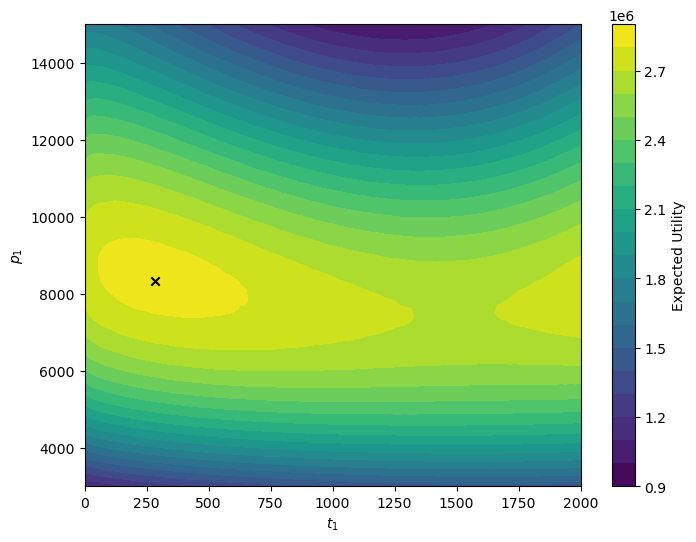

In [122]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
util_vals = resultados[:, 2]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Utility')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

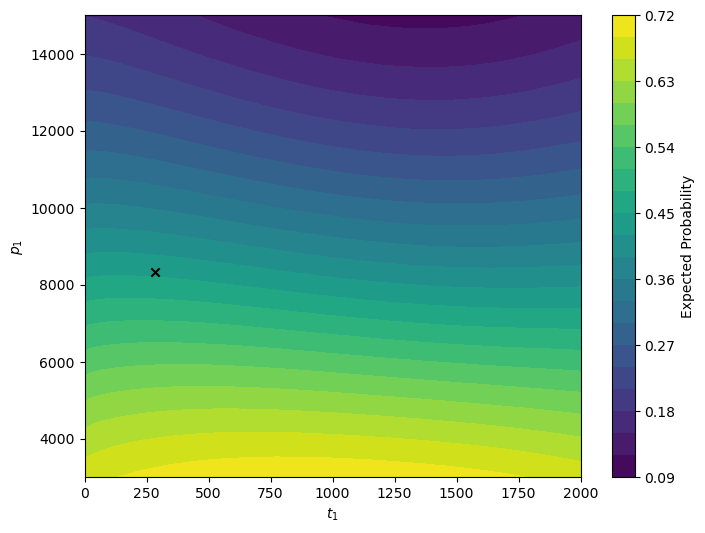

In [123]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
prob_vals = resultados[:, 3]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
prob_matrix = prob_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, prob_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Probability')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

In [125]:
resultados = np.load('results/results_resol.npy')

In [126]:
mejores_precios = []
for i in range(100):
    seleccion = resultados[abs(resultados[:, 1] - np.linspace(0, 2000, 100)[i]) < 1e-1]    
    mejores_precios.append(seleccion[np.argmax(seleccion[:, 2]), 0])

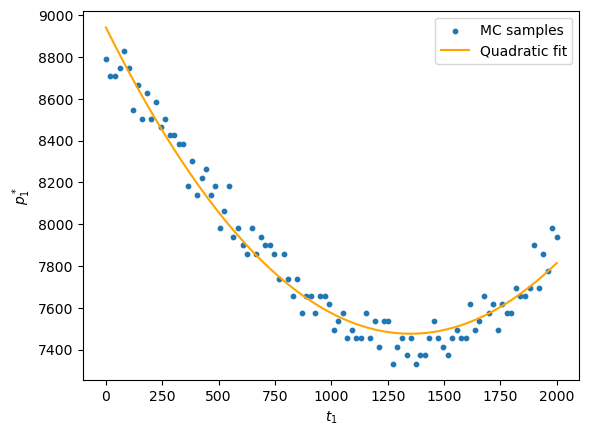

In [127]:
xs = np.linspace(0, 2000, 100)
c, b, a = np.polyfit(xs, mejores_precios, 2)
ys = a + b * xs + c * xs ** 2

plt.scatter(xs, mejores_precios, s=10)
plt.plot(xs, ys, color='orange')
plt.xlabel('$t_1$')
plt.ylabel('$p^*_1$')
plt.legend(['MC samples', 'Quadratic fit'])

In [128]:
trace = az.from_netcdf('trace.nc', engine='h5netcdf')

c11 = 0.2
c21 = 1
c31 = 5
n = 1000
T = 2000

  0%|          | 0/50 [00:00<?, ?it/s]/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
  6%|▌         | 3/50 [00:11<02:56,  3.76s/it]/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encountered in add
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
100%|██████████| 50/50 [03:05<00:00,  3.71s/it]


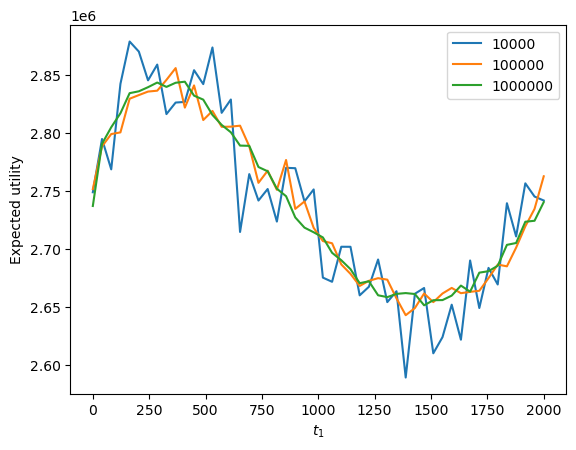

In [129]:
utils = []
utils_vec = []
utils_est = []
p1 = mejor_datos[0]
for t1 in tqdm.tqdm(np.linspace(0, 2000, 50)):
    utils.append(compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, c31, n, T, ite=10000))
    utils_vec.append(compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, c31, n, T, ite=100000))
    utils_est.append(compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, c31, n, T, ite=1000000))

plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_vec])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_est])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')
plt.legend([10000, 100000, 1000000])

In [136]:
resultados_rho = np.load('results/results_rho.npy', allow_pickle=True)

rhos = [None, 1e-8, 1e-7, 1e-6, 5e-6, 1e-5]
for rho in rhos:
    if rho is None:
        seleccion = resultados_rho[[r is None for r in resultados_rho[:, 5]]]   
    else:
        seleccion = resultados_rho[resultados_rho[:, 5] == rho]    
    
    indice_mejor = np.argmax(seleccion[:, 2])
    best = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]
    mejor_profit = seleccion[indice_mejor, 4]

    print(f"Rho: {rho}, p_1: {best[0]:.0f}, t_1: {best[1]:.0f}, Expected utility: {mejor_util:.0f}, Profit: {mejor_profit:.0f}, Probability: {mejor_prob:.2f}")

Rho: None, p_1: 8485, t_1: 303, Expected utility: 2841659, Profit: 2841659, Probability: 0.43
Rho: 1e-08, p_1: 8424, t_1: 283, Expected utility: 2802147, Profit: 2842244, Probability: 0.44
Rho: 1e-07, p_1: 8303, t_1: 303, Expected utility: 2472639, Profit: 2841257, Probability: 0.44
Rho: 1e-06, p_1: 8424, t_1: 283, Expected utility: 941204, Profit: 2842423, Probability: 0.44
Rho: 1e-05, p_1: 8121, t_1: 323, Expected utility: 100000, Profit: 2838771, Probability: 0.45
Rho: 0.0001, p_1: 9152, t_1: 1434, Expected utility: 10000, Profit: 2555027, Probability: 0.35


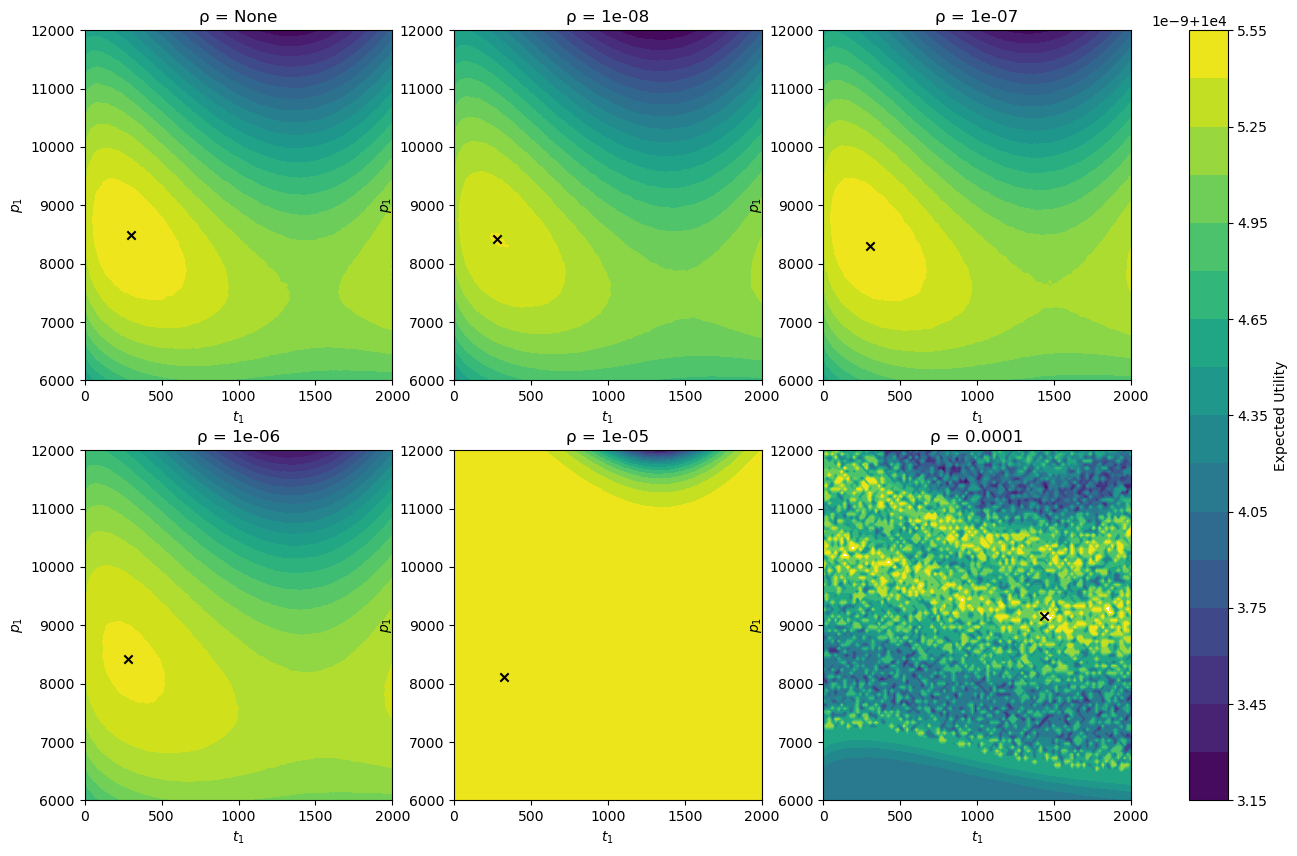

In [159]:
n_rows = 2
n_cols = (len(rhos) + 1) // 2  # Ensure balanced layout

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, rho in zip(axes, rhos):
    seleccion = resultados_rho[resultados_rho[:, 5] == rho]

    if seleccion.size == 0:
        ax.set_title(f'ρ = {rho}\n(No Data)', fontsize=10)
        ax.axis('off')
        continue

    indice_mejor = np.argmax(seleccion[:, 2])
    best = seleccion[indice_mejor, :2]
    p1_vals = seleccion[:, 0]
    t1_vals = seleccion[:, 1]
    util_vals = seleccion[:, 2]

    p1_unique = np.unique(p1_vals)
    t1_unique = np.unique(t1_vals)

    if len(p1_unique) * len(t1_unique) != len(util_vals):
        ax.set_title(f'ρ = {rho}\n(Shape Mismatch)', fontsize=10)
        ax.axis('off')
        continue

    util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))
    util_matrix = np.array(util_matrix, dtype=np.float64)

    contourf = ax.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
    ax.scatter(best[1], best[0], marker='x', c='black')
    ax.set_xlabel('$t_1$')
    ax.set_ylabel('$p_1$')
    ax.set_title(f'ρ = {rho}')

# Remove any unused axes (if len(rhos) < n_rows * n_cols)
for i in range(len(rhos), len(axes)):
    axes[i].axis('off')

fig.colorbar(contourf, ax=axes, label='Expected Utility', orientation='vertical', fraction=0.05)
plt.show()

In [3]:
resultados_c31 = np.load('results/results_c31.npy', allow_pickle=True)

c31s = np.linspace(1, 20, 20)
df_resultados = pd.DataFrame(columns=['c31', 'p1', 't1', 'util', 'prob'])
for c31 in c31s:
    seleccion = resultados_c31[resultados_c31[:, 4] == c31]    
    indice_mejor = np.argmax(seleccion[:, 2])
    mejor_datos = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]

    new_row = pd.DataFrame([{'c31': c31, 'p1': mejor_datos[0], 't1': mejor_datos[1], 'util': mejor_util, 'prob': mejor_prob}])
    df_resultados = pd.concat([df_resultados, new_row], ignore_index=True)

/tmp/ipykernel_2195331/910819853.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, new_row], ignore_index=True)


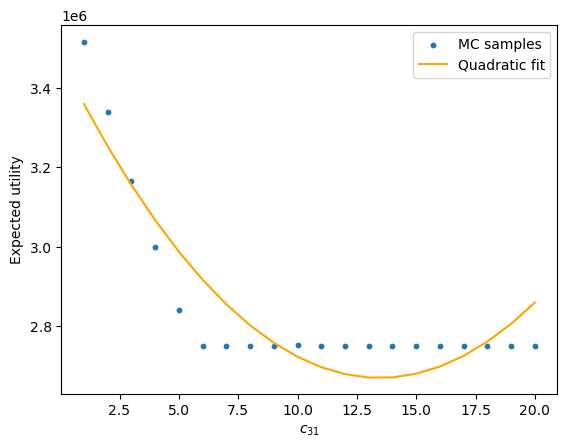

In [4]:
# plot of the expected utility as a function of c31
plt.scatter(df_resultados['c31'], df_resultados['util'], s=10)
c, b, a = np.polyfit(df_resultados['c31'], df_resultados['util'], 2)
var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
plt.plot(df_resultados['c31'], var_fit, color='orange')
plt.xlabel('$c_{31}$')
plt.ylabel('Expected utility')
plt.legend(['MC samples', 'Quadratic fit'])

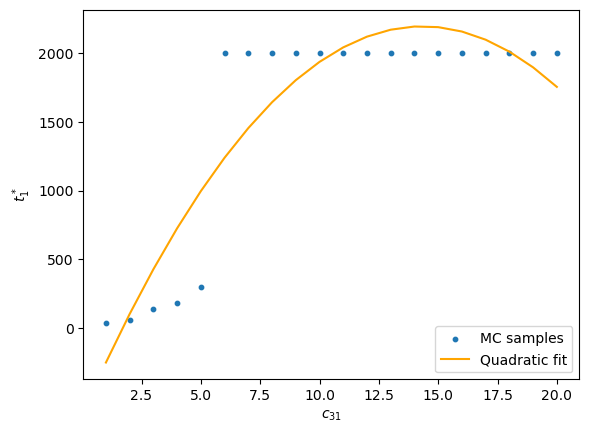

In [5]:
# plot of the optimal t1 as a function of c31
plt.scatter(df_resultados['c31'], df_resultados['t1'], s=10)
c, b, a = np.polyfit(df_resultados['c31'], df_resultados['t1'], 2)
var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
plt.plot(df_resultados['c31'], var_fit, color='orange')
plt.xlabel('$c_{31}$')
plt.ylabel('$t_1^*$')
plt.legend(['MC samples', 'Quadratic fit'])

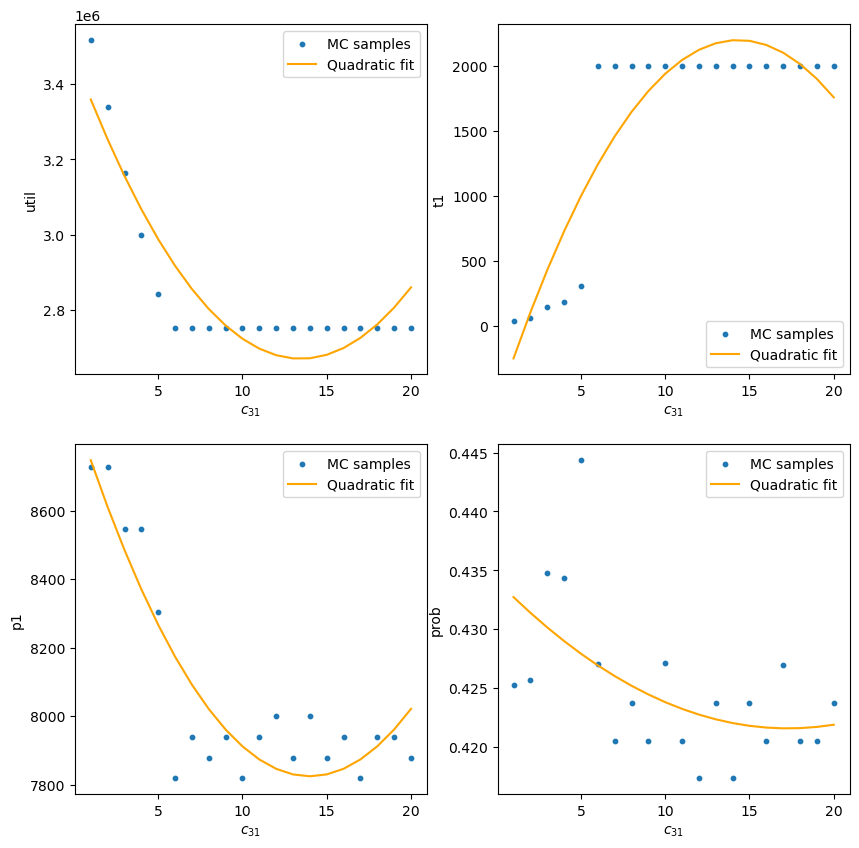

In [6]:
# do 4 subplots for util, t1, c1 and prob in a same figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for var in ['util', 't1', 'p1', 'prob']:
    ax = axs.flatten()[['util', 't1', 'p1', 'prob'].index(var)]
    ax.scatter(df_resultados['c31'], df_resultados[var], s=10)
    c, b, a = np.polyfit(df_resultados['c31'], df_resultados[var], 2)
    var_fit = a + b * df_resultados['c31'] + c * df_resultados['c31'] ** 2
    ax.plot(df_resultados['c31'], var_fit, color='orange')
    ax.set_xlabel('$c_{31}$')
    ax.set_ylabel(var)
    ax.legend(['MC samples', 'Quadratic fit'])

In [ ]:
# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T):
    p1, t1 = params
    return -compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, c31, n, T, ite=100000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200, n_jobs=-1)

# Get the optimal parameters
p1_optimal_gp, t1_optimal_gp = result.x
optimal_utility_gp = -result.fun

print("Optimal p1:", p1_optimal_gp)
print("Optimal t1:", t1_optimal_gp)
print("Optimal utility:", optimal_utility_gp)

/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
/LUSTRE/users/pgarcia/ProductLaunching/prodLaunch.py:113: RuntimeWarning: overflow encou

In [10]:
def generate_neighbor(t1, p1):
    # Generate a neighboring solution by perturbing t1 and p1 within a certain range
    new_t1 = np.clip(t1 + np.random.uniform(-50, 50), 0, 2000)
    new_p1 = np.clip(p1 + np.random.uniform(-200, 200), 3000, 15000)
    return new_t1, new_p1

def simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T, max_iter=1000):
    # Set initial temperature and cooling rate
    temperature = 1000
    cooling_rate = 0.99

    # Initialize current solution
    current_t1, current_p1 = initial_t1, initial_p1
    current_util = compute_expected_utility_vec_random_ac(trace, current_t1, current_p1, c11, c21, c31, n, T, ite=500000)[0]

    # Initialize best solution
    best_t1, best_p1 = current_t1, current_p1
    best_util = current_util

    # Simulated Annealing algorithm
    for _ in tqdm.tqdm(range(max_iter)):
        # Generate a neighboring solution
        new_t1, new_p1 = generate_neighbor(current_t1, current_p1)

        # Calculate the cost of the new solution
        new_util = compute_expected_utility_vec_random_ac(trace, new_t1, new_p1, c11, c21, c31, n, T, ite=500000)[0]

        # Calculate the acceptance probability
        delta_util = new_util - current_util
        acceptance_probability = np.exp(delta_util / temperature)

        # Accept or reject the new solution
        if np.random.uniform() < acceptance_probability:
            current_t1, current_p1 = new_t1, new_p1
            current_util = new_util

        # Update the best solution
        if current_util > best_util:
            best_t1, best_p1 = current_t1, current_p1
            best_util = current_util

        # Cool down the temperature
        temperature *= cooling_rate

    return best_t1, best_p1

# Example usage
initial_t1 = np.random.uniform(0, 2000)
initial_p1 = np.random.uniform(3000, 15000)
t1_optimal_sa, p1_optimal_sa = simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T)
print("Best t_1:", t1_optimal_sa)
print("Best p_1:", p1_optimal_sa)

  1%|          | 11/1000 [00:08<12:31,  1.32it/s]C:\Users\pgarc\AppData\Local\Temp\ipykernel_18420\1937691041.py:31: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
 96%|█████████▌| 957/1000 [11:04<00:28,  1.49it/s]C:\Users\pgarc\AppData\Local\Temp\ipykernel_18420\2545586076.py:36: RuntimeWarning: overflow encountered in exp
  acceptance_probability = np.exp(delta_util / temperature)
100%|██████████| 1000/1000 [11:33<00:00,  1.44it/s]

Best t_1: 705.0057048727372
Best p_1: 9643.579237282085


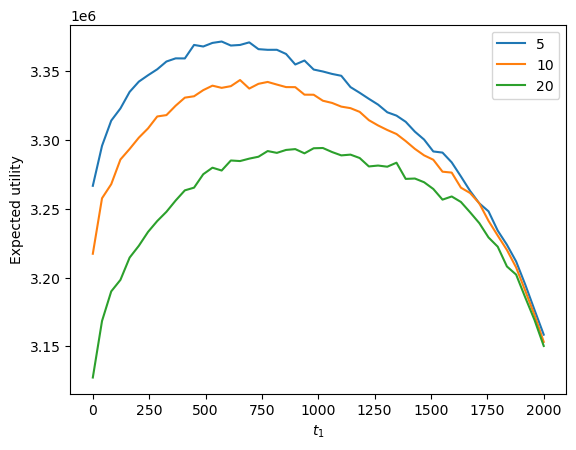

In [35]:
utils = []
utils_vec = []
utils_est = []
p1 = mejor_datos[0]
for t1 in np.linspace(0, 2000, 50):
    utils.append(compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, c31, n, T, ite=1000000, fact=1000))
    utils_vec.append(compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, 10, n, T, ite=1000000, fact=1000))
    utils_est.append(compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, 20, n, T, ite=1000000, fact=1000))

plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_vec])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_est])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')
plt.legend([5, 10, 20])

In [11]:
import time

In [13]:
# Example usage
t1 = mejor_datos[1]
p1 = mejor_datos[0]  
random_ac = []
time_start = time.time()
for i in range(10):
    util, _, _ = compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, c31, n, T, ite=1000000)
    random_ac.append(util)
print(f'Brute force: {p1:.0f}, {t1:.0f}, {np.array(random_ac).mean():.0f}')
print(f'Time: {time.time() - time_start:.4f}')

t1 = t1_optimal_gp
p1 = p1_optimal_gp
random_ac = []
for i in range(10):
    util, _, _ = compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, c31, n, T, ite=1000000)
    random_ac.append(util)

print(f'Bayesian optimization: {p1:.0f}, {t1:.0f}, {np.array(random_ac).mean():.0f}')


t1 = t1_optimal_sa
p1 = p1_optimal_sa
random_ac = []
for i in range(10):
    util, _, _ = compute_expected_utility_vec_random_ac(trace, t1, p1, c11, c21, c31, n, T, ite=1000000)
    random_ac.append(util)

print(f'Simulated annealing: {p1:.0f}, {t1:.0f}, {np.array(random_ac).mean():.0f}')

Brute force: 9788, 485, 3105581
Time: 13.2787
Bayesian optimization: 9667, 615, 3105447
Simulated annealing: 9644, 705, 3102799


# Purchase of multiple items

In [14]:
def knapsack_solver(utilities, prices, budgets):
    # Generar todos los subconjuntos posibles una vez
    subsets = [[0], [1], [0, 1], [2], [0, 2], [1, 2], [0, 1, 2]]

    # Inicializar la cantidad total de ventas
    total_sells = 0

    # Precalcular las sumas de precios y utilidades para cada subconjunto
    prices_sums = np.array([prices[subset, :].sum(axis=0) for subset in subsets])
    utilities_sums = np.array([utilities[subset, :].sum(axis=0) for subset in subsets])

    # Iterar sobre cada presupuesto
    for budget in budgets:
        mask = prices_sums <= budget
        utilities_masked = np.where(mask, utilities_sums, -1000)
        indices = np.argmax(utilities_masked, axis=0)

        # Contar las ventas de productos cuyos índices son pares
        total_sells += (indices % 2 == 0).sum()

    return total_sells

In [15]:
def compute_expected_utility_multiple_items(t1, p1, c11, c21, c31, n, T, ite=5000, rho1=None, fact=100):
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=12000, size=(ite, 2))
    aes = gamma.rvs(.256**2/.2**2, scale=.2**2/.256, size=(ite, 2))  # so it has mean .256 and variance .04
    mean = .837
    std = .2
    cs = beta.rvs(mean*(mean*(1-mean)/std**2-1), (1-mean)*(mean*(1-mean)/std**2-1), size=(ite, 2))
    lambda23Tt = aes * (T ** cs - ts ** cs)
    qs = poisson.rvs(lambda23Tt)

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(10, scale=1/10, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * t1 ** acs[:, 1]
    lambda1_T = acs[:, 0] * T ** acs[:, 1]
    lambda1_Tt = acs[:, 0] * (T ** acs[:, 1] - t1 ** acs[:, 1])
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = poisson.rvs(lambda1_Tt, size=ite)

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT))
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT))

    # Estimating the cost
    c1 = fact * (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Solving the knapsack problem for each buyer
    budgets = np.random.uniform(10000, 20000, (n, ite))

    total_sales = knapsack_solver(
            np.array([u1, u2, u3]), 
            np.array([p1*np.ones([ps.shape[0]]), ps[:, 0], ps[:, 1]]),
            np.array(budgets))

    # Expected utility
    s = total_sales / ite
    util = utility_func(s * p1 - c1, rho1)
    
    profit = s * p1 - c1
    
    return util, profit

In [27]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

p1 = 9000.51515152
t1 = 606.06060606

compute_expected_utility_multiple_items(t1, p1, c11, c21, c31, n, T, ite=1000000)

(2495301.660470527, 2495301.660470527)

Mejores datos: [7484.84848485   60.60606061] Mejor utilidad: 3247936.4607272726


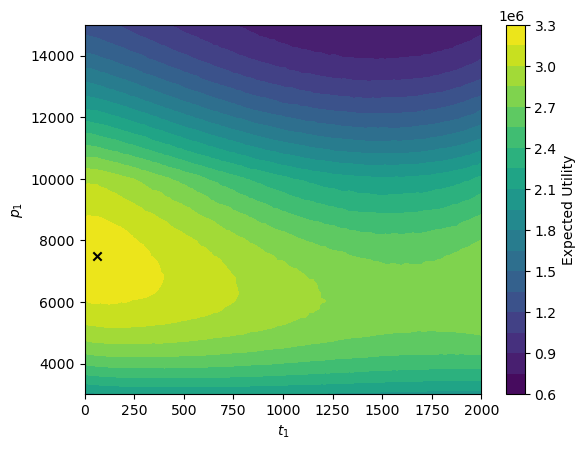

In [3]:
resultados = np.load('results/results_multiple_items_prob.npy')

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util)


p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
util_vals = resultados[:, 2]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))

contourf = plt.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Utility')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

Text(0, 0.5, 'Expected utility')

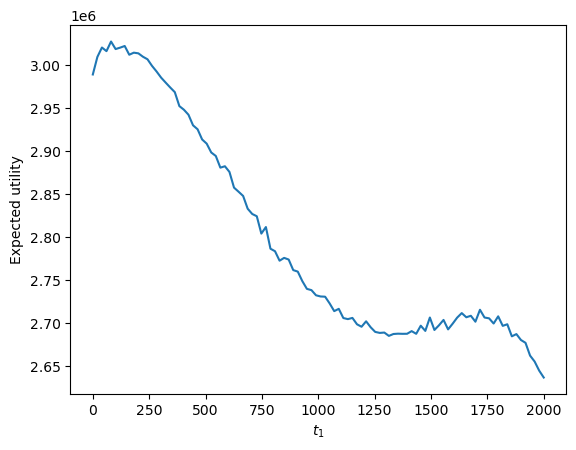

In [35]:
slice_p1 = resultados[resultados[:, 0] == mejor_datos[0]]
plt.plot(slice_p1[:, 1], slice_p1[:, 2])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')

# Intelligent competitors

In [7]:
resultados = np.load('results/results_intelligent_competitors.npy')

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util)

Mejores datos: [7606.06060606  323.23232323] Mejor utilidad: 2479726.0515789944


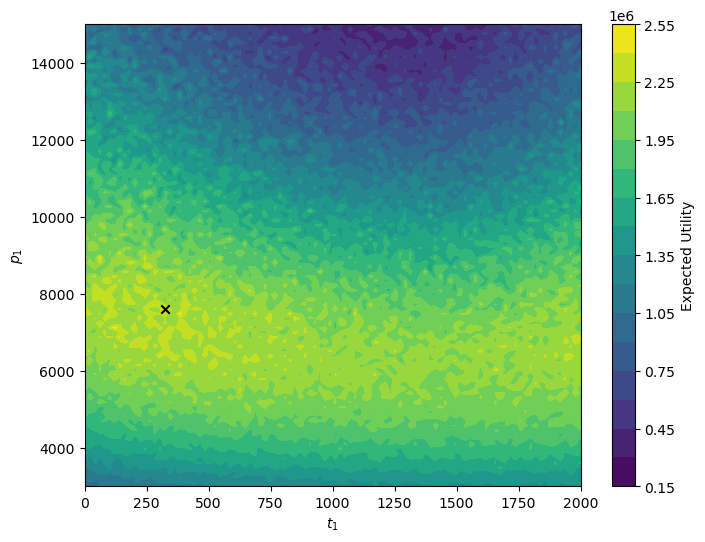

In [8]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
util_vals = resultados[:, 2]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Utility')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

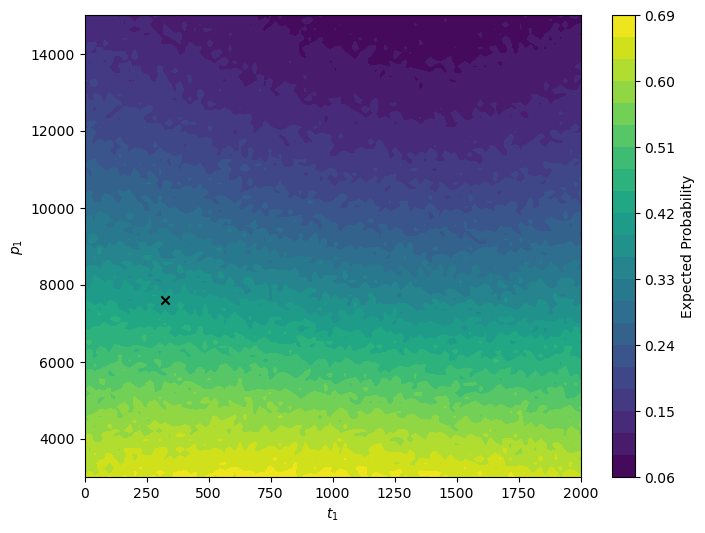

In [9]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
prob_vals = resultados[:, 3]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
prob_matrix = prob_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, prob_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Probability')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()